# DQN for continuous action space


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5559222949356863 -2.856805613150467
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float64, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float64, [None], name='targetQs')
    return states, actions, targetQs

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [17]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    #Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states)
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs)
    g_loss1 = tf.reduce_mean(neg_log_prob_actions)
    g_loss2 = tf.reduce_mean(Qs)
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, Qs, g_loss, d_loss, g_loss1, g_loss2

In [18]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [25]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss1, self.g_loss2 = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [26]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [28]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [29]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [30]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [31]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        gloss1_batch, gloss2_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 0.001
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            # if explore_p > np.random.rand():
            #     action = env.action_space.sample()
            # else:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            #batch = memory.sample(batch_size)
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, gloss1, gloss2, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.g_loss1, model.g_loss2,
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            gloss1_batch.append(gloss1)
            gloss2_batch.append(gloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
                # g_loss1 = tf.reduce_mean(neg_log_prob_actions)
                # g_loss2 = tf.reduce_mean(Qs)
              'gloss1-As:{:.4f}'.format(np.mean(gloss1_batch)),
              'gloss2-Qs:{:.4f}'.format(np.mean(gloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.        
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:31.0000 R:31.0000 gloss:0.0801 dloss:1.0161 gloss1-As:0.6950 gloss2-Qs:0.1151 exploreP:1.0000
Episode:1 meanR:46.0000 R:61.0000 gloss:0.2045 dloss:1.0515 gloss1-As:0.7048 gloss2-Qs:0.2898 exploreP:1.0000
Episode:2 meanR:43.6667 R:39.0000 gloss:0.3809 dloss:1.1243 gloss1-As:0.7020 gloss2-Qs:0.5428 exploreP:1.0000
Episode:3 meanR:39.7500 R:28.0000 gloss:0.5120 dloss:1.1915 gloss1-As:0.6954 gloss2-Qs:0.7363 exploreP:1.0000
Episode:4 meanR:33.4000 R:8.0000 gloss:0.5917 dloss:1.2296 gloss1-As:0.6942 gloss2-Qs:0.8523 exploreP:1.0000
Episode:5 meanR:29.5000 R:10.0000 gloss:0.6368 dloss:1.2532 gloss1-As:0.6941 gloss2-Qs:0.9174 exploreP:1.0000
Episode:6 meanR:26.7143 R:10.0000 gloss:0.6901 dloss:1.2836 gloss1-As:0.6938 gloss2-Qs:0.9946 exploreP:1.0000
Episode:7 meanR:24.7500 R:11.0000 gloss:0.7486 dloss:1.3182 gloss1-As:0.6934 gloss2-Qs:1.0796 exploreP:1.0000
Episode:8 meanR:22.8889 R:8.0000 gloss:0.8038 dloss:1.3511 gloss1-As:0.6930 gloss2-Qs:1.1598 exploreP:1.0000
Episode:9 me

Episode:73 meanR:31.7838 R:13.0000 gloss:11.8282 dloss:14.5735 gloss1-As:0.6224 gloss2-Qs:19.0032 exploreP:0.9998
Episode:74 meanR:31.8667 R:38.0000 gloss:11.8164 dloss:14.5603 gloss1-As:0.6214 gloss2-Qs:19.0156 exploreP:0.9998
Episode:75 meanR:32.0132 R:43.0000 gloss:11.7999 dloss:14.5817 gloss1-As:0.6193 gloss2-Qs:19.0526 exploreP:0.9998
Episode:76 meanR:32.1688 R:44.0000 gloss:11.7857 dloss:14.5999 gloss1-As:0.6169 gloss2-Qs:19.1048 exploreP:0.9998
Episode:77 meanR:32.2564 R:39.0000 gloss:11.7732 dloss:14.6598 gloss1-As:0.6146 gloss2-Qs:19.1568 exploreP:0.9998
Episode:78 meanR:31.9873 R:11.0000 gloss:11.7633 dloss:14.6832 gloss1-As:0.6135 gloss2-Qs:19.1738 exploreP:0.9997
Episode:79 meanR:31.9500 R:29.0000 gloss:11.7515 dloss:14.7064 gloss1-As:0.6130 gloss2-Qs:19.1708 exploreP:0.9997
Episode:80 meanR:32.2222 R:54.0000 gloss:11.7095 dloss:14.6659 gloss1-As:0.6112 gloss2-Qs:19.1568 exploreP:0.9997
Episode:81 meanR:32.2927 R:38.0000 gloss:11.6877 dloss:14.6671 gloss1-As:0.6090 gloss2-Q

Episode:145 meanR:36.8500 R:34.0000 gloss:9.6298 dloss:15.9149 gloss1-As:0.4541 gloss2-Qs:21.2081 exploreP:0.9995
Episode:146 meanR:36.9900 R:40.0000 gloss:9.5941 dloss:15.9476 gloss1-As:0.4514 gloss2-Qs:21.2518 exploreP:0.9995
Episode:147 meanR:36.7200 R:11.0000 gloss:9.5557 dloss:15.9857 gloss1-As:0.4496 gloss2-Qs:21.2537 exploreP:0.9995
Episode:148 meanR:36.6200 R:44.0000 gloss:9.5061 dloss:15.9089 gloss1-As:0.4485 gloss2-Qs:21.1939 exploreP:0.9995
Episode:149 meanR:36.5000 R:36.0000 gloss:9.4790 dloss:15.9312 gloss1-As:0.4462 gloss2-Qs:21.2434 exploreP:0.9995
Episode:150 meanR:36.2300 R:33.0000 gloss:9.4468 dloss:15.9768 gloss1-As:0.4435 gloss2-Qs:21.3025 exploreP:0.9995
Episode:151 meanR:36.3800 R:48.0000 gloss:9.4096 dloss:15.9881 gloss1-As:0.4409 gloss2-Qs:21.3441 exploreP:0.9995
Episode:152 meanR:36.3800 R:54.0000 gloss:9.3358 dloss:16.0239 gloss1-As:0.4363 gloss2-Qs:21.3963 exploreP:0.9995
Episode:153 meanR:36.5100 R:51.0000 gloss:9.2848 dloss:16.0628 gloss1-As:0.4327 gloss2-Q

Episode:217 meanR:37.8600 R:28.0000 gloss:5.7016 dloss:17.5857 gloss1-As:0.2356 gloss2-Qs:24.2047 exploreP:0.9992
Episode:218 meanR:37.9000 R:38.0000 gloss:5.6424 dloss:17.5952 gloss1-As:0.2328 gloss2-Qs:24.2323 exploreP:0.9992
Episode:219 meanR:37.8400 R:30.0000 gloss:5.5824 dloss:17.6262 gloss1-As:0.2299 gloss2-Qs:24.2778 exploreP:0.9992
Episode:220 meanR:37.8900 R:33.0000 gloss:5.5308 dloss:17.6209 gloss1-As:0.2279 gloss2-Qs:24.2675 exploreP:0.9992
Episode:221 meanR:37.8700 R:26.0000 gloss:5.4779 dloss:17.6065 gloss1-As:0.2258 gloss2-Qs:24.2641 exploreP:0.9992
Episode:222 meanR:38.0400 R:55.0000 gloss:5.4260 dloss:17.6642 gloss1-As:0.2228 gloss2-Qs:24.3529 exploreP:0.9992
Episode:223 meanR:38.1200 R:42.0000 gloss:5.3485 dloss:17.6801 gloss1-As:0.2194 gloss2-Qs:24.3832 exploreP:0.9992
Episode:224 meanR:38.5200 R:52.0000 gloss:5.2718 dloss:17.7125 gloss1-As:0.2156 gloss2-Qs:24.4522 exploreP:0.9992
Episode:225 meanR:38.5100 R:46.0000 gloss:5.2065 dloss:17.7654 gloss1-As:0.2120 gloss2-Q

Episode:289 meanR:39.7000 R:62.0000 gloss:0.6380 dloss:19.4683 gloss1-As:0.0227 gloss2-Qs:28.0571 exploreP:0.9989
Episode:290 meanR:39.3800 R:33.0000 gloss:0.6221 dloss:19.4921 gloss1-As:0.0221 gloss2-Qs:28.1028 exploreP:0.9989
Episode:291 meanR:39.3600 R:33.0000 gloss:0.6179 dloss:19.4915 gloss1-As:0.0220 gloss2-Qs:28.1026 exploreP:0.9989
Episode:292 meanR:39.2800 R:35.0000 gloss:0.6132 dloss:19.4742 gloss1-As:0.0219 gloss2-Qs:28.0612 exploreP:0.9989
Episode:293 meanR:39.8500 R:92.0000 gloss:0.5837 dloss:19.5028 gloss1-As:0.0208 gloss2-Qs:28.1294 exploreP:0.9989
Episode:294 meanR:40.1100 R:38.0000 gloss:0.5630 dloss:19.5411 gloss1-As:0.0200 gloss2-Qs:28.2115 exploreP:0.9989
Episode:295 meanR:40.3700 R:40.0000 gloss:0.5586 dloss:19.5102 gloss1-As:0.0199 gloss2-Qs:28.1400 exploreP:0.9989
Episode:296 meanR:39.9600 R:14.0000 gloss:0.5586 dloss:19.4728 gloss1-As:0.0199 gloss2-Qs:28.0580 exploreP:0.9989
Episode:297 meanR:39.7000 R:11.0000 gloss:0.5589 dloss:19.4412 gloss1-As:0.0200 gloss2-Q

Episode:361 meanR:37.7600 R:41.0000 gloss:0.1625 dloss:19.4404 gloss1-As:0.0058 gloss2-Qs:28.0053 exploreP:0.9987
Episode:362 meanR:37.7400 R:28.0000 gloss:0.1575 dloss:19.4771 gloss1-As:0.0056 gloss2-Qs:28.0630 exploreP:0.9987
Episode:363 meanR:37.8500 R:45.0000 gloss:0.1563 dloss:19.4557 gloss1-As:0.0056 gloss2-Qs:28.0304 exploreP:0.9987
Episode:364 meanR:37.9500 R:40.0000 gloss:0.1546 dloss:19.4345 gloss1-As:0.0055 gloss2-Qs:27.9896 exploreP:0.9987
Episode:365 meanR:38.3500 R:72.0000 gloss:0.1524 dloss:19.4392 gloss1-As:0.0054 gloss2-Qs:27.9842 exploreP:0.9987
Episode:366 meanR:38.6800 R:66.0000 gloss:0.1494 dloss:19.4241 gloss1-As:0.0053 gloss2-Qs:27.9593 exploreP:0.9986
Episode:367 meanR:38.8400 R:44.0000 gloss:0.1477 dloss:19.3989 gloss1-As:0.0053 gloss2-Qs:27.9049 exploreP:0.9986
Episode:368 meanR:38.9000 R:41.0000 gloss:0.1475 dloss:19.4037 gloss1-As:0.0053 gloss2-Qs:27.9061 exploreP:0.9986
Episode:369 meanR:38.8600 R:34.0000 gloss:0.1459 dloss:19.3892 gloss1-As:0.0052 gloss2-Q

Episode:433 meanR:40.7500 R:50.0000 gloss:0.0534 dloss:19.7169 gloss1-As:0.0019 gloss2-Qs:28.6122 exploreP:0.9984
Episode:434 meanR:40.7100 R:38.0000 gloss:0.0516 dloss:19.7333 gloss1-As:0.0018 gloss2-Qs:28.6591 exploreP:0.9984
Episode:435 meanR:40.7300 R:44.0000 gloss:0.0503 dloss:19.7430 gloss1-As:0.0018 gloss2-Qs:28.6713 exploreP:0.9984
Episode:436 meanR:40.5400 R:12.0000 gloss:0.0498 dloss:19.7452 gloss1-As:0.0017 gloss2-Qs:28.6309 exploreP:0.9984
Episode:437 meanR:40.6600 R:44.0000 gloss:0.0492 dloss:19.7047 gloss1-As:0.0017 gloss2-Qs:28.5873 exploreP:0.9984
Episode:438 meanR:40.8800 R:56.0000 gloss:0.0482 dloss:19.7077 gloss1-As:0.0017 gloss2-Qs:28.6106 exploreP:0.9984
Episode:439 meanR:41.0600 R:30.0000 gloss:0.0470 dloss:19.7258 gloss1-As:0.0016 gloss2-Qs:28.6328 exploreP:0.9983
Episode:440 meanR:40.8900 R:31.0000 gloss:0.0465 dloss:19.7338 gloss1-As:0.0016 gloss2-Qs:28.6269 exploreP:0.9983
Episode:441 meanR:40.7200 R:9.0000 gloss:0.0468 dloss:19.7276 gloss1-As:0.0016 gloss2-Qs

Episode:505 meanR:39.4300 R:48.0000 gloss:0.0262 dloss:19.5707 gloss1-As:0.0009 gloss2-Qs:28.2749 exploreP:0.9981
Episode:506 meanR:38.9600 R:9.0000 gloss:0.0266 dloss:19.5923 gloss1-As:0.0009 gloss2-Qs:28.2484 exploreP:0.9981
Episode:507 meanR:39.0500 R:38.0000 gloss:0.0264 dloss:19.5179 gloss1-As:0.0009 gloss2-Qs:28.1724 exploreP:0.9981
Episode:508 meanR:38.8500 R:16.0000 gloss:0.0277 dloss:19.5465 gloss1-As:0.0010 gloss2-Qs:28.1645 exploreP:0.9981
Episode:509 meanR:38.8500 R:30.0000 gloss:0.0289 dloss:19.5044 gloss1-As:0.0010 gloss2-Qs:28.1184 exploreP:0.9981
Episode:510 meanR:38.9600 R:41.0000 gloss:0.0286 dloss:19.5057 gloss1-As:0.0010 gloss2-Qs:28.1244 exploreP:0.9981
Episode:511 meanR:38.4200 R:29.0000 gloss:0.0288 dloss:19.5060 gloss1-As:0.0010 gloss2-Qs:28.1367 exploreP:0.9981
Episode:512 meanR:38.6300 R:32.0000 gloss:0.0279 dloss:19.4801 gloss1-As:0.0010 gloss2-Qs:28.0901 exploreP:0.9981
Episode:513 meanR:38.5600 R:37.0000 gloss:0.0260 dloss:19.5178 gloss1-As:0.0009 gloss2-Qs

Episode:577 meanR:37.6500 R:85.0000 gloss:0.0211 dloss:19.4835 gloss1-As:0.0008 gloss2-Qs:28.1022 exploreP:0.9978
Episode:578 meanR:37.7900 R:45.0000 gloss:0.0208 dloss:19.5240 gloss1-As:0.0007 gloss2-Qs:28.1640 exploreP:0.9978
Episode:579 meanR:37.7300 R:32.0000 gloss:0.0214 dloss:19.5186 gloss1-As:0.0008 gloss2-Qs:28.1725 exploreP:0.9978
Episode:580 meanR:38.0800 R:52.0000 gloss:0.0212 dloss:19.5390 gloss1-As:0.0008 gloss2-Qs:28.1924 exploreP:0.9978
Episode:581 meanR:38.0000 R:30.0000 gloss:0.0208 dloss:19.5131 gloss1-As:0.0007 gloss2-Qs:28.1734 exploreP:0.9978
Episode:582 meanR:38.0100 R:30.0000 gloss:0.0205 dloss:19.5217 gloss1-As:0.0007 gloss2-Qs:28.1481 exploreP:0.9978
Episode:583 meanR:38.4300 R:54.0000 gloss:0.0187 dloss:19.5280 gloss1-As:0.0007 gloss2-Qs:28.1988 exploreP:0.9978
Episode:584 meanR:38.1900 R:39.0000 gloss:0.0180 dloss:19.5543 gloss1-As:0.0006 gloss2-Qs:28.2253 exploreP:0.9978
Episode:585 meanR:38.4900 R:77.0000 gloss:0.0177 dloss:19.5286 gloss1-As:0.0006 gloss2-Q

Episode:649 meanR:38.1500 R:34.0000 gloss:0.0134 dloss:19.3066 gloss1-As:0.0005 gloss2-Qs:27.7007 exploreP:0.9976
Episode:650 meanR:38.3100 R:54.0000 gloss:0.0132 dloss:19.3359 gloss1-As:0.0005 gloss2-Qs:27.7402 exploreP:0.9976
Episode:651 meanR:38.2000 R:32.0000 gloss:0.0130 dloss:19.3548 gloss1-As:0.0005 gloss2-Qs:27.7618 exploreP:0.9976
Episode:652 meanR:38.1200 R:32.0000 gloss:0.0129 dloss:19.3231 gloss1-As:0.0005 gloss2-Qs:27.7307 exploreP:0.9976
Episode:653 meanR:37.9300 R:48.0000 gloss:0.0128 dloss:19.3345 gloss1-As:0.0005 gloss2-Qs:27.7459 exploreP:0.9976
Episode:654 meanR:37.9400 R:38.0000 gloss:0.0126 dloss:19.3056 gloss1-As:0.0005 gloss2-Qs:27.7045 exploreP:0.9976
Episode:655 meanR:37.7300 R:15.0000 gloss:0.0119 dloss:19.4015 gloss1-As:0.0004 gloss2-Qs:27.7963 exploreP:0.9976
Episode:656 meanR:37.8500 R:53.0000 gloss:0.0119 dloss:19.3223 gloss1-As:0.0004 gloss2-Qs:27.7340 exploreP:0.9975
Episode:657 meanR:37.5100 R:31.0000 gloss:0.0117 dloss:19.3510 gloss1-As:0.0004 gloss2-Q

Episode:721 meanR:37.1900 R:56.0000 gloss:0.0074 dloss:19.1717 gloss1-As:0.0003 gloss2-Qs:27.3769 exploreP:0.9973
Episode:722 meanR:37.4300 R:62.0000 gloss:0.0075 dloss:19.1559 gloss1-As:0.0003 gloss2-Qs:27.3664 exploreP:0.9973
Episode:723 meanR:37.3900 R:42.0000 gloss:0.0074 dloss:19.1662 gloss1-As:0.0003 gloss2-Qs:27.4035 exploreP:0.9973
Episode:724 meanR:37.5900 R:54.0000 gloss:0.0073 dloss:19.2157 gloss1-As:0.0003 gloss2-Qs:27.4825 exploreP:0.9973
Episode:725 meanR:37.5800 R:37.0000 gloss:0.0071 dloss:19.2124 gloss1-As:0.0003 gloss2-Qs:27.4935 exploreP:0.9973
Episode:726 meanR:37.3800 R:35.0000 gloss:0.0070 dloss:19.2299 gloss1-As:0.0003 gloss2-Qs:27.5103 exploreP:0.9973
Episode:727 meanR:37.3700 R:37.0000 gloss:0.0069 dloss:19.2055 gloss1-As:0.0003 gloss2-Qs:27.4565 exploreP:0.9973
Episode:728 meanR:37.2900 R:32.0000 gloss:0.0068 dloss:19.1792 gloss1-As:0.0002 gloss2-Qs:27.3896 exploreP:0.9973
Episode:729 meanR:37.6600 R:46.0000 gloss:0.0067 dloss:19.1700 gloss1-As:0.0002 gloss2-Q

Episode:793 meanR:38.3400 R:38.0000 gloss:0.0045 dloss:19.3071 gloss1-As:0.0002 gloss2-Qs:27.7096 exploreP:0.9970
Episode:794 meanR:38.3800 R:39.0000 gloss:0.0045 dloss:19.3267 gloss1-As:0.0002 gloss2-Qs:27.7116 exploreP:0.9970
Episode:795 meanR:38.7400 R:50.0000 gloss:0.0043 dloss:19.3240 gloss1-As:0.0002 gloss2-Qs:27.7310 exploreP:0.9970
Episode:796 meanR:38.5900 R:39.0000 gloss:0.0042 dloss:19.3333 gloss1-As:0.0002 gloss2-Qs:27.7462 exploreP:0.9970
Episode:797 meanR:38.4600 R:19.0000 gloss:0.0044 dloss:19.3720 gloss1-As:0.0002 gloss2-Qs:27.7763 exploreP:0.9970
Episode:798 meanR:38.4100 R:32.0000 gloss:0.0044 dloss:19.3153 gloss1-As:0.0002 gloss2-Qs:27.7320 exploreP:0.9970
Episode:799 meanR:38.3800 R:36.0000 gloss:0.0043 dloss:19.3008 gloss1-As:0.0002 gloss2-Qs:27.6900 exploreP:0.9970
Episode:800 meanR:38.2500 R:32.0000 gloss:0.0043 dloss:19.3353 gloss1-As:0.0002 gloss2-Qs:27.6854 exploreP:0.9970
Episode:801 meanR:38.4300 R:46.0000 gloss:0.0043 dloss:19.2936 gloss1-As:0.0002 gloss2-Q

Episode:865 meanR:37.2300 R:15.0000 gloss:0.0037 dloss:19.2364 gloss1-As:0.0001 gloss2-Qs:27.4060 exploreP:0.9968
Episode:866 meanR:37.3200 R:52.0000 gloss:0.0036 dloss:19.1563 gloss1-As:0.0001 gloss2-Qs:27.3490 exploreP:0.9968
Episode:867 meanR:37.2800 R:34.0000 gloss:0.0035 dloss:19.1615 gloss1-As:0.0001 gloss2-Qs:27.3759 exploreP:0.9968
Episode:868 meanR:37.4000 R:77.0000 gloss:0.0035 dloss:19.1830 gloss1-As:0.0001 gloss2-Qs:27.4107 exploreP:0.9968
Episode:869 meanR:37.4300 R:37.0000 gloss:0.0034 dloss:19.2000 gloss1-As:0.0001 gloss2-Qs:27.4655 exploreP:0.9968
Episode:870 meanR:37.7200 R:58.0000 gloss:0.0034 dloss:19.2080 gloss1-As:0.0001 gloss2-Qs:27.4812 exploreP:0.9967
Episode:871 meanR:37.3400 R:34.0000 gloss:0.0033 dloss:19.2171 gloss1-As:0.0001 gloss2-Qs:27.5439 exploreP:0.9967
Episode:872 meanR:37.2500 R:29.0000 gloss:0.0033 dloss:19.3297 gloss1-As:0.0001 gloss2-Qs:27.6107 exploreP:0.9967
Episode:873 meanR:38.1900 R:107.0000 gloss:0.0031 dloss:19.3094 gloss1-As:0.0001 gloss2-

Episode:937 meanR:38.6500 R:67.0000 gloss:0.0023 dloss:19.3500 gloss1-As:0.0001 gloss2-Qs:27.7666 exploreP:0.9965
Episode:938 meanR:38.8900 R:39.0000 gloss:0.0022 dloss:19.3408 gloss1-As:0.0001 gloss2-Qs:27.7731 exploreP:0.9965
Episode:939 meanR:38.8800 R:34.0000 gloss:0.0022 dloss:19.3438 gloss1-As:0.0001 gloss2-Qs:27.7873 exploreP:0.9965
Episode:940 meanR:38.9000 R:38.0000 gloss:0.0023 dloss:19.3996 gloss1-As:0.0001 gloss2-Qs:27.8296 exploreP:0.9965
Episode:941 meanR:39.0200 R:40.0000 gloss:0.0022 dloss:19.3473 gloss1-As:0.0001 gloss2-Qs:27.7554 exploreP:0.9965
Episode:942 meanR:39.2000 R:28.0000 gloss:0.0022 dloss:19.3089 gloss1-As:0.0001 gloss2-Qs:27.6950 exploreP:0.9965
Episode:943 meanR:38.9700 R:32.0000 gloss:0.0021 dloss:19.3084 gloss1-As:0.0001 gloss2-Qs:27.6823 exploreP:0.9965
Episode:944 meanR:39.0000 R:37.0000 gloss:0.0021 dloss:19.3027 gloss1-As:0.0001 gloss2-Qs:27.6013 exploreP:0.9965
Episode:945 meanR:38.9200 R:32.0000 gloss:0.0021 dloss:19.2381 gloss1-As:0.0001 gloss2-Q

Episode:1009 meanR:38.0100 R:15.0000 gloss:0.0013 dloss:19.2663 gloss1-As:0.0000 gloss2-Qs:27.5489 exploreP:0.9962
Episode:1010 meanR:38.1100 R:54.0000 gloss:0.0013 dloss:19.2215 gloss1-As:0.0000 gloss2-Qs:27.4811 exploreP:0.9962
Episode:1011 meanR:38.0600 R:36.0000 gloss:0.0012 dloss:19.2169 gloss1-As:0.0000 gloss2-Qs:27.5114 exploreP:0.9962
Episode:1012 meanR:38.1100 R:40.0000 gloss:0.0012 dloss:19.2377 gloss1-As:0.0000 gloss2-Qs:27.5299 exploreP:0.9962
Episode:1013 meanR:37.8000 R:33.0000 gloss:0.0012 dloss:19.2616 gloss1-As:0.0000 gloss2-Qs:27.5922 exploreP:0.9962
Episode:1014 meanR:37.9500 R:46.0000 gloss:0.0013 dloss:19.2511 gloss1-As:0.0000 gloss2-Qs:27.5619 exploreP:0.9962
Episode:1015 meanR:37.8400 R:34.0000 gloss:0.0014 dloss:19.2571 gloss1-As:0.0001 gloss2-Qs:27.5358 exploreP:0.9962
Episode:1016 meanR:37.9100 R:41.0000 gloss:0.0014 dloss:19.2098 gloss1-As:0.0000 gloss2-Qs:27.5130 exploreP:0.9962
Episode:1017 meanR:37.9900 R:43.0000 gloss:0.0013 dloss:19.2468 gloss1-As:0.0000

Episode:1081 meanR:33.9000 R:37.0000 gloss:0.0010 dloss:19.0689 gloss1-As:0.0000 gloss2-Qs:27.1862 exploreP:0.9960
Episode:1082 meanR:33.9200 R:13.0000 gloss:0.0009 dloss:19.1196 gloss1-As:0.0000 gloss2-Qs:27.1966 exploreP:0.9960
Episode:1083 meanR:33.7800 R:28.0000 gloss:0.0009 dloss:19.0338 gloss1-As:0.0000 gloss2-Qs:27.1236 exploreP:0.9960
Episode:1084 meanR:34.1800 R:50.0000 gloss:0.0010 dloss:19.0526 gloss1-As:0.0000 gloss2-Qs:27.1148 exploreP:0.9960
Episode:1085 meanR:34.1800 R:40.0000 gloss:0.0010 dloss:19.0390 gloss1-As:0.0000 gloss2-Qs:27.1202 exploreP:0.9960
Episode:1086 meanR:33.9600 R:14.0000 gloss:0.0010 dloss:19.0906 gloss1-As:0.0000 gloss2-Qs:27.1274 exploreP:0.9960
Episode:1087 meanR:33.9400 R:32.0000 gloss:0.0010 dloss:18.9861 gloss1-As:0.0000 gloss2-Qs:27.0306 exploreP:0.9960
Episode:1088 meanR:33.9000 R:34.0000 gloss:0.0010 dloss:19.0304 gloss1-As:0.0000 gloss2-Qs:27.0306 exploreP:0.9960
Episode:1089 meanR:33.9500 R:36.0000 gloss:0.0010 dloss:19.0059 gloss1-As:0.0000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

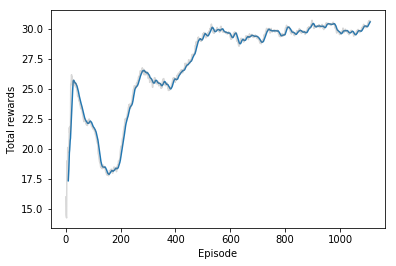

In [87]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

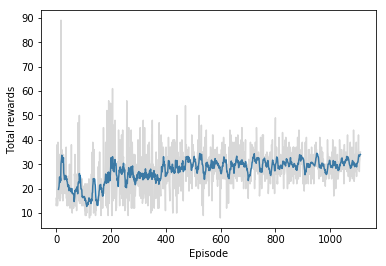

In [88]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

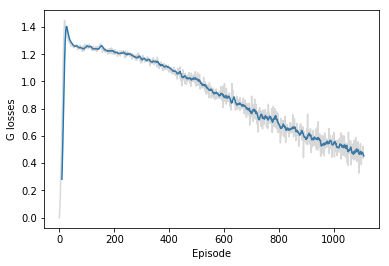

In [89]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

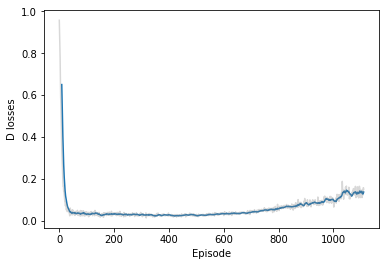

In [90]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.